In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
workers=7
random_crop=False
pseudo_label=False
# val_folder = 'sample_test_sync'
val_folder = 'test_sync'
# val_folder = 'val'
S_PREFIX = '43-conv-lstm'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
        
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    if pad_right == 32: pad_right = 0
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [16]:
def convert_y(y_img):
    yr = (y_img==ROADS) | (y_img==ROAD_LINES)
    yc = (y_img==VEHICLES)
    cutoff_y = int(yc.shape[0]*.875)
    yc[cutoff_y:,:] = 0
    rn = ~(yr | yc)
    return torch.from_numpy(np.stack((rn,yc,yr)).astype(int))

def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y(y_img[:,:,0])

In [17]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [18]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False, pseudo_label=False, val_folder=None):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
    
    if pseudo_label:
        x_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraRGB{f_ext}/*.png')))
        y_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraSeg{f_ext}/*.png')))
        x_names = np.concatenate((x_names, x_names_test))
        x_names = np.concatenate((y_names, y_names_test))
        print(f'Pseudo-Labels: {len(x_names_test)}')
    if val_folder:
        x_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraRGB{f_ext}/*.png')))
        y_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraSeg{f_ext}/*.png')))
        val_x,val_y = x_names_val, y_names_val
        trn_x,trn_y = x_names, y_names
        print(f'Val Labels:', len(val_x))
    else:
        ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    print(f'Val x:{len(val_x)}, y:{len(val_y)}')
    print(f'Trn x:{len(trn_x)}, y:{len(trn_y)}')
    print(f'All x:{len(x_names)}')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=False,
#         train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [19]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    x_np = x_np*std+mean
    return x_np

## U-net (ish)

In [20]:
from torchvision.models import vgg11_bn

In [21]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [22]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [23]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [24]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [25]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [26]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

In [27]:
def car_f_p_r(pred, targs):
#     p2 = F.sigmoid(pred)
    _,idx = torch.max(pred, 1)
    p2 = idx
    return fbeta_score(p2==1, targs[:,1,:,:], beta=2)

In [28]:
def rd_f(pred, targs):
    _,idx = torch.max(pred, 1)
#     p2 = F.sigmoid(pred)
    p2 = idx
    f,p,r = fbeta_score(p2==2, targs[:,2,:,:], beta=0.5)
    return f

In [29]:
def fbeta_score(y_pred, y_true, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [30]:
def new_acc(pred, targs):
    _,idx = torch.max(pred, 1)
    _,t_idx = torch.max(targs,1)
#     idx = F.softmax(pred) > 0.5
    return (idx == t_idx).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [31]:
def dice_coeff_weight(pred, target, weight):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2)
    w = V(weight.view(1,-1,1))
    i_w = (w*intersection).sum()
    m1_w = (w*m1).sum()
    m2_w = (w*m2).sum()
    return (2. * i_w + smooth) / (m1_w + m2_w + smooth)

def dice_coeff(pred, target):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()
        self.weight = weight

    def forward(self, logits, targets):
        probs = F.softmax(logits)
        num = targets.size(0)  # Number of batches
        if isinstance(logits.data, torch.cuda.HalfTensor):
            targets = targets.half()
        else:
            targets = targets.float()
            
        if self.weight is not None:
            score = dice_coeff_weight(probs, targets, self.weight)
        else:
            score = dice_coeff(probs, targets)
        score = 1 - score.sum() / num
        return score

In [32]:
from fastai.lm_rnn import repackage_var

In [33]:
class Unet34ModOld(nn.Module):
    def __init__(self, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        
        
        self.sz = np.array([3,7])
        self.rn_k = 512
        self.nl = 1
        self.rn_input = int(self.rn_k * self.sz[0] * self.sz[1])
        self.lstm_input = 256
        
        
        self.bidirectional = True
        self.bmult = 2 if self.bidirectional else 1
        self.n_hidden = int(self.lstm_input / self.bmult)
        self.lstm = torch.nn.LSTM(self.lstm_input, self.n_hidden, self.nl, dropout=0.2, bidirectional=self.bidirectional)
        self.bs = 1
#         self.reset_all_hidden(self.bs)
        self.reset_all_hidden(self.bs)
    
        self.ln1 = nn.Linear(self.rn_input, self.lstm_input)
        self.ln2 = nn.Linear(self.lstm_input, self.rn_input)
    
    
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,16,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        self.x_skip = nn.Sequential(
            nn.Conv2d(3,16,1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        
        
    def forward(self,x):
        x_skip = self.x_skip(x)
        x = self.rn(x)
        pre_shape = x.shape
        x = x.view(x.shape[0], -1)
        x = self.ln1(x)
        x = x.unsqueeze_(1)
#         print('Resnet output:', x.shape)
        x, h1 = self.lstm(x, self.h1)
        self.h1 = repackage_var(h1)
        x = x.squeeze_()
        x = self.ln2(x)
#         print('RNN output:', x.shape)
        x = x.view(*pre_shape)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, x_skip)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
            
    def reset_all_hidden(self, bs):
        self.h1 = self.init_hidden(bs)
        
    def init_hidden(self, bs):
        h1 = torch.autograd.Variable(torch.zeros(self.nl*self.bmult, bs, self.n_hidden))
        h2 = torch.autograd.Variable(torch.zeros(self.nl*self.bmult, bs, self.n_hidden))
#         if cuda_enabled:
        return (h1.cuda(), h2.cuda())
#         return h1, h2

In [34]:
class Unet34Mod(nn.Module):
    def __init__(self, sz, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        
        
        self.sz = sz
#         self.sz = np.array([3,7])
        self.rn_k = 512
        self.nl = 1
        self.rn_input = int(self.rn_k * self.sz[0] * self.sz[1])
        self.lstm_output = 512
        
        
        self.bidirectional = False
        self.bmult = 2 if self.bidirectional else 1
        self.n_hidden = int(self.lstm_output / self.bmult)
        self.lstm = torch.nn.LSTM(self.rn_input, self.n_hidden, self.nl, dropout=0.2, bidirectional=self.bidirectional)
        self.bs = 1
#         self.reset_all_hidden(self.bs)
        self.reset_all_hidden(self.bs)
    
        self.ln1 = nn.Linear(self.lstm_output, self.rn_input)
#         self.ln2 = nn.Linear(self.lstm_input, self.rn_input)
    
    
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(1024,256,512)
        self.up2 = UnetBlock(512,128,256)
        self.up3 = UnetBlock(256,64,128)
        self.up4 = UnetBlock(128,64,64)
        self.up5 = UnetBlock(64,32,32)
        self.up6 = nn.ConvTranspose2d(32, 3, 1)
        self.x_skip = nn.Sequential(
            nn.Conv2d(3,32,1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        
    def forward(self,x):
        x_skip = self.x_skip(x)
        x = self.rn(x)
        
        x_rnn = x.view(x.shape[0], 1, -1)
        x_rnn, h1 = self.lstm(x_rnn, self.h1)
        self.h1 = repackage_var(h1)
        x_rnn = x_rnn.squeeze()
        x_rnn = self.ln1(x_rnn)
        x_rnn = x.view(*x.shape)
        x = torch.cat((x, x_rnn), dim=1)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, x_skip)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
            
    def reset_all_hidden(self, bs):
        self.h1 = self.init_hidden(bs)
        
    def init_hidden(self, bs):
        h1 = torch.autograd.Variable(torch.zeros(self.nl*self.bmult, bs, self.n_hidden))
        h2 = torch.autograd.Variable(torch.zeros(self.nl*self.bmult, bs, self.n_hidden))
#         if cuda_enabled:
        return (h1.cuda(), h2.cuda())
#         return h1, h2

In [35]:
def get_learner(md, sz, half=False):
    m = Unet34Mod(sz)
    m = to_gpu(m)
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.cuda.FloatTensor([1,150,1])
    if half:
        class_weights = class_weights.half()
        learn.half()
#     learn.crit=nn.CrossEntropyLoss(weight=class_weights)
    learn.crit=SoftDiceLoss(weight=class_weights)
    learn.metrics=[new_acc, rd_f, car_f_p_r]
    return learn

In [78]:
%pdb off

Automatic pdb calling has been turned OFF


In [79]:
ext = '-150'
sz = 96
bs = 16
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 1000
Val x:1000, y:1000
Trn x:4600, y:4600
All x:4600


In [80]:
learn = get_learner(md)

/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [81]:
lr=1e-2
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [82]:
%pdb off

Automatic pdb calling has been turned OFF


In [83]:
learn.fit(lr,1,wds=wd,cycle_len=1,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.956948   0.967871   0.945131   0.928249   0.005482   0.447644   0.004424  



[0.9678710851669311,
 0.9451313247680664,
 0.9282494387626647,
 0.005481927261222154,
 0.4476444444656372,
 0.004424393789842725]

### Settings

In [84]:
ext = '-150'
sz = 96
bs = 128
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 1000
Val x:1000, y:1000
Trn x:4600, y:4600
All x:4600


/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
# learn.half()

In [85]:
learn.freeze_to(1)

In [ ]:
%pdb on

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.998252   0.998946   0.29868    0.347303   0.000458   0.004717   0.000374  



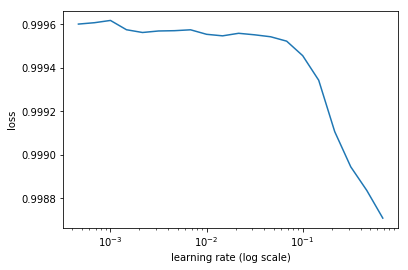

In [86]:
learn.lr_find()
learn.sched.plot()

In [87]:
lr=1e-2
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [88]:
learn.fit(lr,1,wds=wd,cycle_len=30,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.999548   0.99957    0.566958   0.293285   0.023553   0.668129   0.019053  
    1      0.999266   0.998397   0.617578   0.440909   0.648476   0.501968   0.712163  
    2      0.998137   0.997087   0.626865   0.454431   0.314222   0.377018   0.315234  
    3      0.996654   0.995194   0.701618   0.557817   0.575725   0.644279   0.569086  
    4      0.995664   0.994784   0.842974   0.751503   0.658341   0.519015   0.719328  
    5      0.995032   0.994862   0.854657   0.821883   0.616587   0.521764   0.664411  
    6      0.994571   0.998479   0.670369   0.656454   0.303402   0.084676   0.867574  
    7      0.99435    0.994752   0.895523   0.882821   0.685681   0.478795   0.784519  
    8      0.994194   0.994689   0.89863    0.850796   0.656837   0.51397    0.724356  
    9      0.994042   0.995592   0.864915   0.784403   0.641335   0.344197   0.846053  
    10     0.993986   0.994314   0.911498   0.879404 

[0.9938300137519837,
 0.9536703858375549,
 0.944539891242981,
 0.6700404758453369,
 0.753019320487976,
 0.6582686276435852]

In [90]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [91]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [92]:
learn.unfreeze()
learn.bn_freeze(True)

In [93]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [94]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.993302   0.993898   0.957261   0.943069   0.603339   0.835344   0.569495  
    1      0.993309   0.993817   0.955379   0.939295   0.638496   0.804695   0.612723  
    2      0.99325    0.993696   0.962754   0.954185   0.658318   0.82187    0.632234  
    3      0.993203   0.993625   0.964029   0.956658   0.704582   0.772029   0.694999  
    4      0.993171   0.993577   0.966514   0.95811    0.699742   0.799333   0.683869  
    5      0.993128   0.993574   0.965302   0.954856   0.697306   0.805722   0.67927   
    6      0.993102   0.993583   0.961736   0.941148   0.688835   0.822019   0.666547  
    7      0.99309    0.993562   0.96389    0.965799   0.740368   0.745501   0.744216  
    8      0.993062   0.993524   0.967505   0.965476   0.745371   0.750748   0.748952  
    9      0.993033   0.993488   0.969489   0.96613    0.737498   0.776076   0.733061  



[0.9934877600669861,
 0.9694888439178467,
 0.9661295232772827,
 0.7374980611801147,
 0.77607563829422,
 0.7330613236427307]

In [96]:
learn.fit(lrs/20, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.993007   0.993497   0.969217   0.966106   0.746173   0.759684   0.74764   
    1      0.993004   0.993483   0.969326   0.968062   0.74527    0.766488   0.744745  
    2      0.992994   0.993479   0.969607   0.967924   0.748957   0.76233    0.750329  
    3      0.99299    0.993465   0.970323   0.967311   0.746558   0.771629   0.745042  
    4      0.992985   0.993455   0.970896   0.96701    0.741661   0.782386   0.736511  
    5      0.992978   0.993445   0.971055   0.967139   0.736489   0.795296   0.72728   
    6      0.992974   0.993442   0.971251   0.967538   0.733038   0.801575   0.721783  
    7      0.992969   0.99344    0.971375   0.96798    0.732777   0.802734   0.721237  
    8      0.992965   0.993436   0.971512   0.967443   0.736894   0.798122   0.727179  
    9      0.992963   0.993435   0.971538   0.967386   0.737336   0.79816    0.727687  



[0.9934347214698791,
 0.971537672996521,
 0.9673857355117798,
 0.737336049079895,
 0.7981598505973816,
 0.7276867814064026]

In [97]:
learn.save(f'128urn-{S_PREFIX}-0')

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:10])))

In [ ]:
# py = np.argmax(py,1)

In [ ]:
show_img(denorm(x[0]))

In [ ]:
py.shape

In [ ]:
show_img(py[0][0]>0.5);

In [ ]:
show_img(py[0][1]>0.5);

In [ ]:
show_img(y[0][1]);

## 256x256

In [44]:
ext = '-300'
sz=192
bs=64
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 1000
Val x:1000, y:1000
Trn x:4600, y:4600
All x:4600


In [45]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [46]:
import gc
gc.collect()

0

In [47]:
md.trn_ds[0][0].shape

torch.Size([3, 192, 416])

In [48]:
a,b,c = md.trn_ds[0][0].shape

In [49]:
m_sz = np.array([b//32,c//32])
learn = get_learner(md, m_sz)

/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [50]:
learn.freeze_to(1)

In [51]:
learn.fit(lrs,1, wds=wd,cycle_len=30,use_clr_beta=(20,20,0.95,0.85))

 17%|█▋        | 12/72 [00:09<00:47,  1.25it/s, loss=0.999]
epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.998974   0.998155   0.512387   0.275771   0.492833   0.175148   0.972715  
    1      0.997941   0.995525   0.602931   0.406848   0.7006     0.359487   0.940418  
    2      0.992772   0.989518   0.792433   0.684277   0.770133   0.550245   0.865473  
    3      0.988321   0.986991   0.962584   0.956977   0.783979   0.690286   0.813605  
    4      0.986835   0.986594   0.957307   0.967912   0.789973   0.766107   0.798736  
    5      0.986227   0.986549   0.966934   0.973734   0.785012   0.767942   0.792898  
    6      0.985956   0.98654    0.971722   0.975717   0.790215   0.757696   0.802135  
    7      0.985783   0.986186   0.971003   0.976204   0.798398   0.824741   0.794345  
    8      0.985708   0.99189    0.834333   0.744143   0.548539   0.318214   0.699907  
    9      0.985805   0.986474   0.949435   0.962588   0.776609   0.817335   0.77

[0.9858263325691223,
 0.9839693932533264,
 0.98382701587677,
 0.808047966003418,
 0.8780391607284546,
 0.7948795404434205]

In [ ]:
learn.lr_find()
learn.sched.plot()

In [52]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [53]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [54]:
learn.unfreeze()
learn.bn_freeze(True)

In [55]:
learn.fit(lrs/20,1, wds=wd,cycle_len=30,use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.985125   0.985831   0.983815   0.984071   0.802383   0.886054   0.786565  
    1      0.985119   0.985818   0.983622   0.984487   0.806382   0.882488   0.791954  
    2      0.985112   0.985805   0.984098   0.983941   0.809825   0.878887   0.796772  
    3      0.985105   0.985805   0.984317   0.983992   0.808495   0.880624   0.794902  
    4      0.985099   0.985811   0.984482   0.984057   0.806221   0.883008   0.791869  
    5      0.98509    0.985801   0.984636   0.983704   0.807785   0.882875   0.793716  
    6      0.985083   0.985797   0.984743   0.983177   0.808509   0.883024   0.79456   
    7      0.985075   0.985813   0.984654   0.98385    0.802135   0.889685   0.785869  
    8      0.985068   0.985807   0.984811   0.984019   0.805646   0.885363   0.790818  
    9      0.98506    0.985782   0.985029   0.984446   0.807035   0.888077   0.791713  
    10     0.985054   0.985793   0.985126   0.98539  

[0.9857010035514832,
 0.986281436920166,
 0.9866316795349122,
 0.8127929096221924,
 0.8971788854598999,
 0.7966229948997497]

In [56]:
learn.save(f'256urn-{S_PREFIX}')

## Let's try different weights

In [57]:
def get_learner(md, sz, half=False):
    m = Unet34Mod(sz)
    m = to_gpu(m)
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.cuda.FloatTensor([1,4,2])
    if half:
        class_weights = class_weights.half()
        learn.half()
#     learn.crit=nn.CrossEntropyLoss(weight=class_weights)
    learn.crit=SoftDiceLoss(weight=class_weights)
    learn.metrics=[new_acc, rd_f, car_f_p_r]
    return learn

In [58]:
ext = '-300'
sz=192
bs=64
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 1000
Val x:1000, y:1000
Trn x:4600, y:4600
All x:4600


In [59]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [60]:
import gc
gc.collect()

0

In [61]:
md.trn_ds[0][0].shape

torch.Size([3, 192, 416])

In [62]:
a,b,c = md.trn_ds[0][0].shape

In [67]:
m_sz = np.array([b//32,c//32])
learn = get_learner(md, m_sz)

/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [68]:
learn.freeze_to(1)

In [69]:
learn.fit(lrs,1, wds=wd,cycle_len=30,use_clr_beta=(20,20,0.95,0.85))

  0%|          | 0/72 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1524590031827/work/aten/src/THC/generic/THCStorage.cu:58

In [ ]:
x,y = next(iter(md.trn_dl))

In [ ]:
x.shape

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:8])))

In [ ]:
plt.imshow(denorm(x[0]))

In [ ]:
py.shape

In [ ]:
show_img(py[0][0]>0);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[-1]);

### No Crop

In [ ]:
ext = '-300'
sz=192
bs=32
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, val_folder)

In [ ]:
learn = get_learner(md)

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lr=1e-3
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [ ]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

In [ ]:
learn.save(f'256urn-{S_PREFIX}-nocrop')

## 512x512

In [ ]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

learn = get_learner(md)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
# learn.load(f'256urn-{S_PREFIX}')
learn.load(f'256urn-{S_PREFIX}-nocrop')

In [ ]:
learn.freeze_to(1)

In [ ]:
lr=1e-3
wd=5e-7

In [ ]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(10,4))

In [ ]:
learn.fit(lr/4,1, wds=wd, cycle_len=4,use_clr=(10,4))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/200,lr/20,lr])/2

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.fit(lrs/40,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.save(f'600urn-{S_PREFIX}')

In [ ]:
learn.sched.plot_loss()

### No Crop

In [ ]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, val_folder)

learn = get_learner(md)

In [ ]:
import gc
gc.collect()

In [ ]:
learn.load(f'600urn-{S_PREFIX}')
# learn.load(f'256urn-{S_PREFIX}-nocrop')
# learn.load('600urn-19-weights-26-r8')

In [ ]:
lr=5e-4
wd=5e-7
lrs = np.array([lr/200,lr/20,lr])/2

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs,1, wds=wd,cycle_len=4,use_clr=(20,2))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-nocrop-tmp')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-nocrop-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,2))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-nocrop-tmp-2')

In [ ]:
learn.fit(lrs/100,1, wds=wd,cycle_len=4,use_clr=(20,2))

In [ ]:
learn.fit(lrs/50,1, wds=wd,cycle_len=4,use_clr_beta=(20,20,0.95,0.85))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-nocrop')

### Visualize Results

In [ ]:
learn.load(f'600urn-36-resnet-softmax-nocrop-tmp')

In [ ]:
val_it = iter(md.val_dl)

In [ ]:
x,y = next(val_it)

In [ ]:
x[1].mean()

In [ ]:
x.shape

In [ ]:
type(x)

In [ ]:
res = learn.model(V(x).cuda())

In [ ]:
mx,idx = torch.max(res,1)
idx = idx.cpu().data.numpy()

In [ ]:
idx.shape

In [ ]:
type(idx)

In [ ]:
i=0

In [ ]:
plt.imshow(denorm(x[i]))

In [ ]:
show_img(idx[i]);

In [ ]:
idx[0].mean()

In [ ]:
show_img(py[idx][1]);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[idx][0]);

## Save results

In [ ]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [ ]:
m = Unet34()

In [ ]:
cuda_enabled = torch.cuda.is_available()
DATA_PATH = Path('../data/all')
model_path = str(DATA_PATH/'models/600urn-36-resnet-softmax-nocrop-tmp.h5')
# model_path = str(PATH/'models/600urn-19-weights-26-r9.h5')
if cuda_enabled:
    m = m.cuda()
    m.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
else:
    m.load_state_dict(torch.load(model_path))


In [ ]:

# file = sys.argv[-1]

R_PATH = Path.cwd()
file = R_PATH/'test_video.mp4'
mismatched_idxs = []
student_output = R_PATH/'tester_data_crop'
ans_key = R_PATH/'results.json'

# R_PATH = Path('../data/lyft-answers')
# file = R_PATH/'test_video.mp4'
# ans_key = R_PATH/'results.json'
# mismatched_idxs = list(range(15,44)) + list(range(200,750))
# student_output = R_PATH/'tester_data_crop'

if file == 'demo.py':
  print ("Error loading video")
  quit

# Define encoder function
def encode(array):
	pil_img = Image.fromarray(array)
	buff = BytesIO()
	pil_img.save(buff, format="PNG")
	return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)


In [ ]:
imagenet_stats = torch.cuda.FloatTensor([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
def normalize(x):
    if x.mean() > 1:
        x.div_(255.0)
    m,s = imagenet_stats
#     return TVF.normalize(x, m, s)
#     print(x.shape)
    x.sub_(m.view(-1, 1, 1))
    x.div_(s.view(-1, 1, 1))
    return x

def crop_bg(x):
    # Original
    h = x.shape[2]
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    return x[:,:,top:bot,:]

def pad(x):
#     print(x.shape)
    # Original
    b,c,w,h = x.shape
#     print(x.shape)
    if h%32 == 0:
        return x, 0
    pad_right=32-h%32
    if pad_right:
        x = F.pad(x, (0,pad_right,0,0), 'constant', 0)
    return x, pad_right
    
def undo(idx):
    idx
    idx = F.pad(idx, (0,0,226,54), "constant", 0)

def preprocess(video):
#     f1 = video[:,200:520,:,:]
    f1 = np.rollaxis(video, 3, 1)
    f1 = torch.from_numpy(f1).float().cuda()
    f1 = crop_bg(f1)
    f1 = normalize(f1)
    return f1.contiguous()

In [ ]:
video_p = preprocess(video)
if len(video_p) == 31:
    video_p = torch.cat((video_p[:15], video_p[16:]))

In [ ]:
import gc
gc.collect()

In [ ]:
results = []
raw_results = []
raw_frames = []
answer_key = {}
bs = 4

        
for i in range(0,video_p.shape[0],bs):
    x = video_p[i:i+bs]
    
#     x = torch.from_numpy(f1).contiguous().float()
#     if cuda_enabled:
#         x = x.cuda()
        
    x,p = pad(x)
    preds = m(torch.autograd.Variable(x))
#     preds = F.sigmoid(preds)
    # Indexes
    mx,idx = torch.max(preds, 1)
    for i in idx:
        raw_frames.append(i.data.cpu().numpy())
    if p > 0:
        idx = idx[:,:,:-p]
    idx = F.pad(idx, (0,0,160,56), "constant", 0)
    frame_idx = 1+i
    for frame in idx:
        frame = frame.data.cpu().numpy()
#         results.append(frame)
        raw_frames.append(frame)
        binary_car_result = (frame==1).astype('uint8')
        binary_road_result = (frame==2).astype('uint8')
#         answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
        raw_results.append([binary_car_result, binary_road_result])
        results.append([encode(binary_car_result), encode(binary_road_result)])
        frame_idx+=1
    
    # Preds
#     if p > 0:
#         preds = preds[:,:,:,:-p]
#     preds = F.pad(preds, (0,0,160,56,0,0), "constant", 0)
#     frame_idx = 1+i
#     for frame in preds:
#         frame = frame.data.cpu().float().numpy()
#         f_results.append(frame)
#         binary_car_result = (frame[0]>0.5).astype('uint8')
#         binary_road_result = (frame[1]>0.5).astype('uint8')
#         answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
#         raw_results.append([binary_car_result, binary_road_result])
#         results.append([encode(binary_car_result), encode(binary_road_result)])
#         frame_idx+=1

In [ ]:
type(video_p.cpu())

In [ ]:
type(x)

In [ ]:
video_p[0,:,50:200,700:].sum(), x[0,:,50:200,700:].cuda().sum()

In [ ]:
video_p[0].shape

In [ ]:
x[0].shape

In [ ]:
x[0][2][200].cuda().sum()

In [ ]:
(video_p[0] - x[0].cuda()).sum()

In [ ]:
md.val_ds.fnames

In [ ]:
show_idx = 0

In [ ]:
video_p[show_idx].mean(), x[show_idx].mean()

In [ ]:
plt.imshow(denorm(x[0]))

In [ ]:
plt.imshow(denorm(video_p[show_idx]))

In [ ]:
learn_res = learn.model(V(video_p[0:4]))

In [ ]:
_,learn_idx = torch.max(learn_res,1)
learn_idx = learn_idx.cpu().data.numpy()

In [ ]:
plt.imshow(learn_idx[show_idx])

In [ ]:
learn_dl_res = learn.model(V(x[0:4].cuda()))

In [ ]:
_,learn_dl_idx = torch.max(learn_dl_res,1)
learn_dl_idx = learn_dl_idx.cpu().data.numpy()

In [ ]:
plt.imshow(learn_dl_idx[show_idx])

In [ ]:
m_dl_res = m(V(x.cuda()))

In [ ]:
_,m_dl_idx = torch.max(m_dl_res,1)
m_dl_idx = m_dl_idx.cpu().data.numpy()

In [ ]:
plt.imshow(m_dl_idx[show_idx])

In [ ]:
m.train()

In [ ]:
m_res = m(V(video_p[0:4]))

In [ ]:
_,m_idx = torch.max(m_res,1)
m_idx = m_idx.cpu().data.numpy()

In [ ]:
plt.imshow(m_idx[show_idx])

In [ ]:
plt.imshow(m_idx[show_idx])

In [ ]:
a = video_p[:6]

In [ ]:
b = x[:6].cuda()

In [ ]:

m_res2 = m(V(a))

In [ ]:
m_res2.shape

In [ ]:
_,m_idx2 = torch.max(m_res2,1)
m_idx2 = m_idx2.cpu().data.numpy()

In [ ]:
m_idx2.shape

In [ ]:
plt.imshow(m_idx2[0])

In [ ]:
idx = 0
plt.figure()
plt.imshow(video[idx])
plt.imshow((raw_results[idx][0]==1).data, alpha=.4)
plt.show()

In [ ]:
for i in range(1, len(results)//10*10+1):
    s_idx = i if i in mismatched_idxs else i-1
#     s_idx = i-1
    answer_key[i] = results[s_idx]

In [ ]:
# Print output in proper json format
tester_data = json.dumps(answer_key)
with open(student_output, 'w') as f:
    f.write(tester_data)
# print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
def decode(packet):
	img = base64.b64decode(packet)
	filename = R_PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open(ans_key) as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

# Load student data
with open(student_output) as student_data:
	student_ans_data = json.loads(student_data.read())
	student_data.close()

frames_processed = 0

Car_TP = 1 # True Positives
Car_FP = 1 # Flase Positives
Car_TN = 1 # True Negatives
Car_FN = 1 # True Negatives

Road_TP = 1 # True Positives
Road_FP = 1 # Flase Positives
Road_TN = 1 # True Negatives
Road_FN = 1 # True Negatives

for frame in range(1,len(ans_data.keys())+1):
    if frame%3 == 0: continue
    truth_data_car =  decode(ans_data[str(frame)][0])
    truth_data_road =  decode(ans_data[str(frame)][1])
    student_data_car = decode(student_ans_data[str(frame)][0])
    student_data_road = decode(student_ans_data[str(frame)][1])
#     student_data_car = results[frame-1][0]
#     student_data_road = results[frame-1][1]
#     student_data_car = f_results[frame-1][0]
#     student_data_road = f_results[frame-1][1]
#     print(np.mean(student_data_road == 1))
#     print(np.mean(student_data_road_f == 1))
#     pdb.set_trace()

    Car_TP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 1))
    Car_FP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 0))
    Car_TN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 0))
    Car_FN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 1))

    Road_TP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 1))
    Road_FP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 0))
    Road_TN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 0))
    Road_FN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 1))

    frames_processed+=1


# Generate results
Car_precision = Car_TP/(Car_TP+Car_FP)/1.0
Car_recall = Car_TP/(Car_TP+Car_FN)/1.0
Car_beta = 2
Car_F = (1+Car_beta**2) * ((Car_precision*Car_recall)/(Car_beta**2 * Car_precision + Car_recall))
Road_precision = Road_TP/(Road_TP+Road_FP)/1.0
Road_recall = Road_TP/(Road_TP+Road_FN)/1.0
Road_beta = 0.5
Road_F = (1+Road_beta**2) * ((Road_precision*Road_recall)/(Road_beta**2 * Road_precision + Road_recall))

print ("Car F score: %05.3f  | Car Precision: %05.3f  | Car Recall: %05.3f  |\n\
Road F score: %05.3f | Road Precision: %05.3f | Road Recall: %05.3f | \n\
Averaged F score: %05.3f" %(Car_F,Car_precision,Car_recall,Road_F,Road_precision,Road_recall,((Car_F+Road_F)/2.0)))

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()